   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

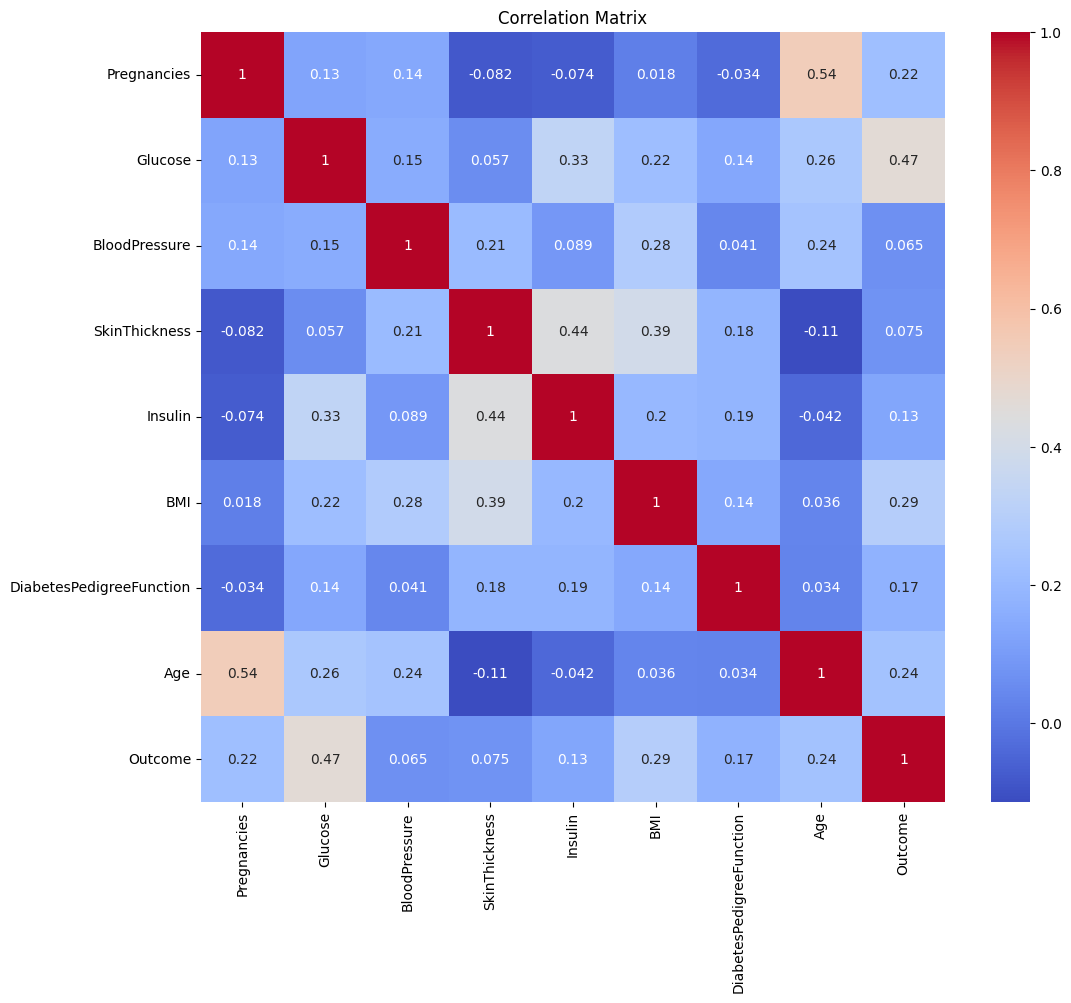

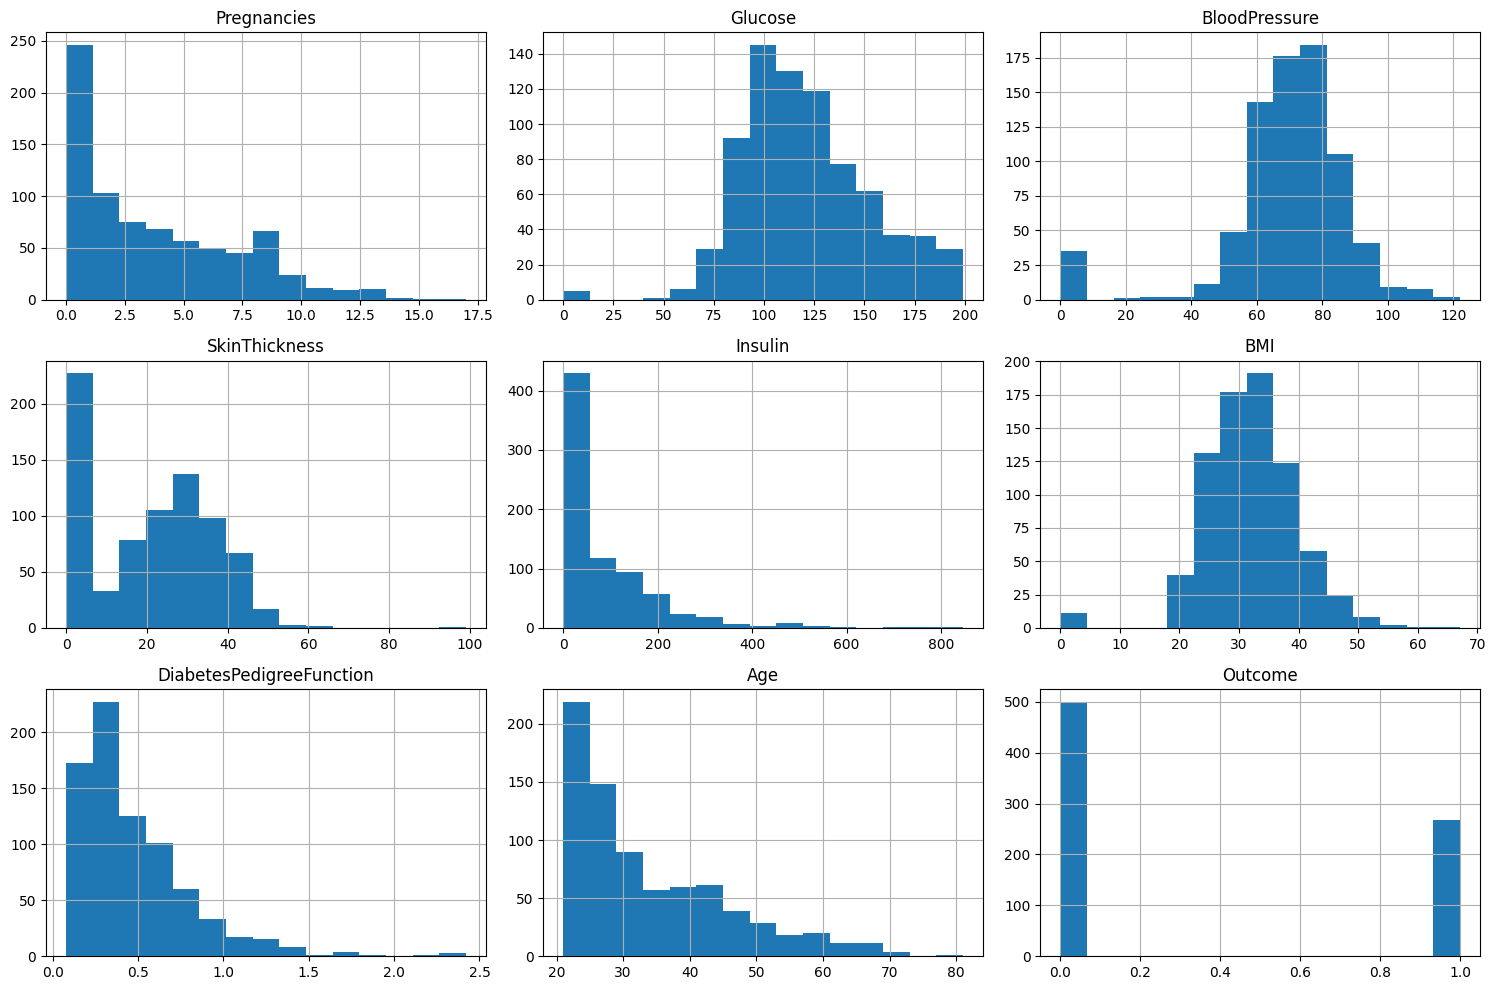

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = "https://drive.google.com/uc?export=download&id=1Q4J8KS1wm4-_YTuc389enPh6O-eTNcx2"
data = pd.read_csv(url)

# Display the first few rows of the dataset
print(data.head())

# Descriptive statistics
print(data.describe())

# Visualizations
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Histograms for each variable
data.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.tight_layout()
plt.show()


In [2]:
# Check for missing values
print(data.isnull().sum())

# Since there are no missing values, we'll proceed with outlier removal if necessary

# Outlier detection and removal using IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_out

data_cleaned = remove_outliers(data)

# Check the shape of the dataset before and after removing outliers
print(f"Original shape: {data.shape}")
print(f"Shape after removing outliers: {data_cleaned.shape}")

# If necessary, replace zero values in certain columns with the median of the column
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in columns_with_zeros:
    data_cleaned[column] = data_cleaned[column].replace(0, data_cleaned[column].median())

# Check for zero values again
print((data_cleaned[columns_with_zeros] == 0).sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Original shape: (768, 9)
Shape after removing outliers: (639, 9)
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


<ipython-input-2-6161f8c5612c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].replace(0, data_cleaned[column].median())
<ipython-input-2-6161f8c5612c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].replace(0, data_cleaned[column].median())
<ipython-input-2-6161f8c5612c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [3]:
from sklearn.model_selection import train_test_split

# Define features and target
X = data_cleaned.drop(columns=['Outcome'])
y = data_cleaned['Outcome']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (447, 8)
Test set shape: (192, 8)


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

# Initialize the model
dt = DecisionTreeClassifier(random_state=42)

# Define hyperparameters for grid search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Train the model with the best parameters
best_dt = grid_search.best_estimator_
best_dt.fit(X_train, y_train)


Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score: 0.7471910112359551


DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       random_state=42)

Accuracy: 0.7552083333333334
Precision: 0.6756756756756757
Recall: 0.4166666666666667
F1 Score: 0.5154639175257731


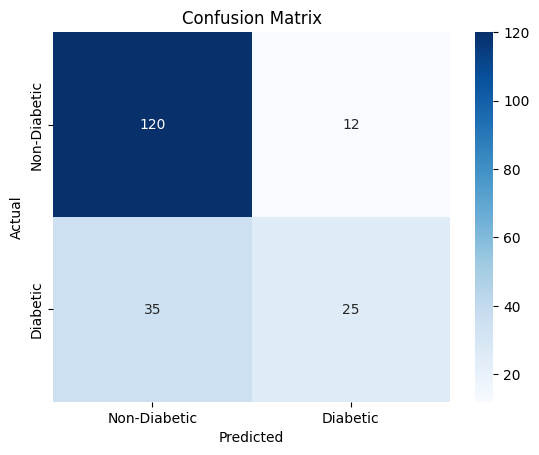

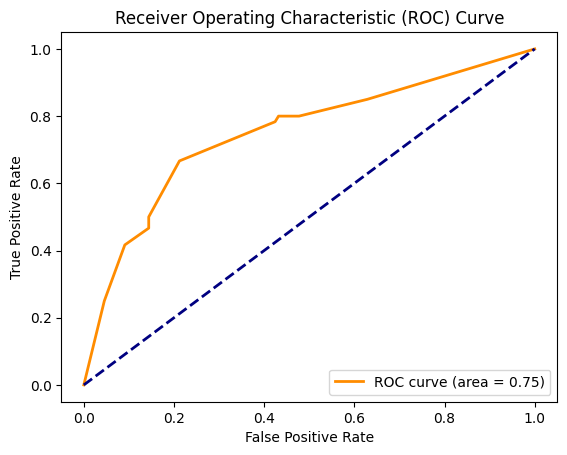

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Make predictions on the test set
y_pred = best_dt.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
y_prob = best_dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


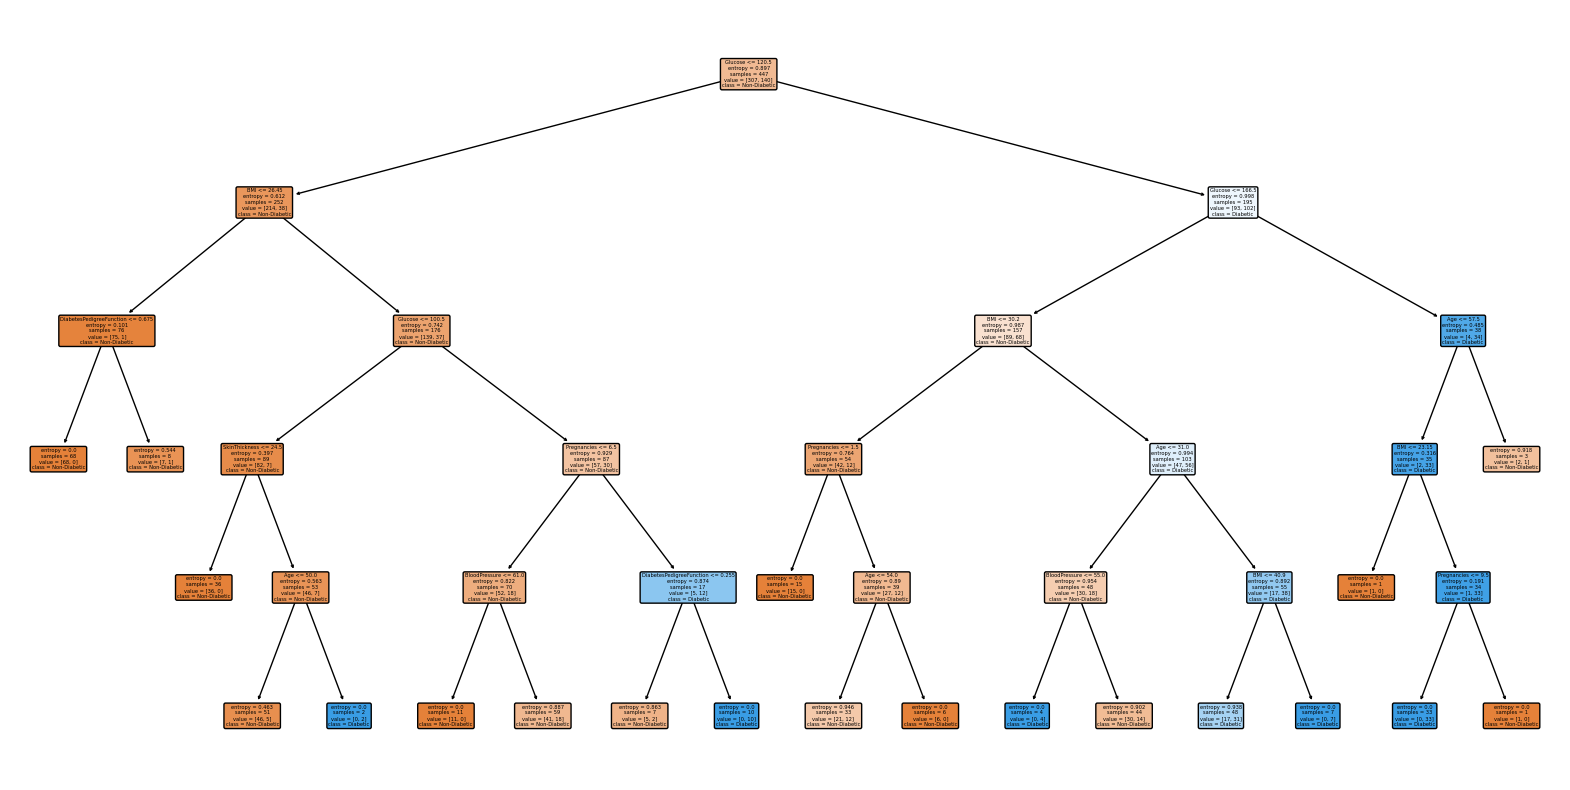

                    Feature  Importance
1                   Glucose    0.447481
5                       BMI    0.182766
7                       Age    0.112081
0               Pregnancies    0.109647
6  DiabetesPedigreeFunction    0.062027
2             BloodPressure    0.057788
3             SkinThickness    0.028210
4                   Insulin    0.000000


In [6]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, filled=True, feature_names=X.columns, class_names=['Non-Diabetic', 'Diabetic'], rounded=True)
plt.show()

# Print feature importances
importances = best_dt.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)


In [7]:
# Sensitivity analysis and scenario testing
# Example: Slightly modify the input features and observe changes in predictions

# Create a new sample with slight variations
new_sample = X_test.iloc[0].copy()
new_sample['Glucose'] += 10
new_sample['BMI'] -= 2

# Predict with the modified sample
new_prediction = best_dt.predict([new_sample])
print(f"Original Prediction: {y_test.iloc[0]}")
print(f"New Prediction with Modified Sample: {new_prediction[0]}")


Original Prediction: 0
New Prediction with Modified Sample: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
